In [27]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib as mpl

In [6]:
!pwd

/home/shard777/code/rs-uk/pictionary-ai/notebooks


# RAW EXAMPLE

Example taken from the simplfied database on : 
https://console.cloud.google.com/storage/browserquickdraw_dataset/full/raw

In [7]:
current_dir = os.getcwd()

data_path = os.path.join(os.path.join(os.path.join(current_dir,'..'),'raw_data'),'face.ndjson')

In [8]:
data_path

'/home/shard777/code/rs-uk/pictionary-ai/notebooks/../raw_data/face.ndjson'

In [9]:
#file_path = "/home/shard777/code/rs-uk/pictionary-ai/raw_data/face.ndjson"

In [10]:
# Take too much time - DONT DO IT Friends!
#df = pd.read_json(file, lines = True)


In [11]:
#RAW DATA: Example 
df = pd.DataFrame()
with open(data_path, 'r') as f:
     for i, line in enumerate(f):
            if i > 0:
                break

            json_line = json.loads(line)
            df = pd.concat([df, pd.DataFrame(json_line)], ignore_index=True)
#             print(type(json_line))
#             print(json_line.keys())
#             print(json_line['word'], len(json_line['drawing']))
            coords = json_line['drawing']
    
            for vector in coords:
                print(len(vector))
                print(vector)
           

3
[[318, 312, 306, 300, 294, 289, 283, 278, 270, 264, 260, 256, 254, 250, 247, 244, 242, 239, 237, 234, 232, 229, 227, 225, 223, 221, 220, 218, 216, 215, 214, 213, 211, 209, 208, 207, 206, 205, 203, 201, 201, 201, 201, 201, 201, 201, 201, 201, 202, 203, 205, 207, 210, 212, 215, 217, 220, 224, 227, 232, 235, 241, 247, 253, 259, 265, 271, 276, 282, 291, 298, 304, 310, 316, 321, 328, 336, 343, 349, 355, 363, 369, 374, 381, 389, 400, 407, 412, 420, 433, 438, 445, 453, 458, 469, 476, 481, 486, 494, 503, 508, 516, 525, 530, 538, 546, 554, 561, 569, 574, 580, 587, 595, 601, 607, 613, 618, 625, 632, 637, 648, 654, 659, 663, 666, 670, 674, 676, 678, 681, 684, 687, 690, 692, 695, 697, 700, 702, 702, 704, 704, 704, 704, 704, 704, 704, 704, 704, 703, 703, 701, 700, 697, 696, 693, 691, 688, 683, 680, 677, 674, 671, 666, 663, 657, 651, 645, 639, 632, 626, 620, 614, 609, 604, 595, 590, 585, 577, 569, 563, 558, 553, 548, 543, 535, 525, 520, 514, 509, 500, 494, 487, 478, 472, 465, 456, 450, 444, 435, 4

In [12]:
df

,word,countrycode,timestamp,recognized,key_id,drawing
0,face,CH,2017-03-19 15:52:39.229 UTC,True,5152530285723648,"[[318, 312, 306, 300, 294, 289, 283, 278, 270,..."
1,face,CH,2017-03-19 15:52:39.229 UTC,True,5152530285723648,"[[351, 351, 351, 347, 341, 335, 329, 323, 317,..."
2,face,CH,2017-03-19 15:52:39.229 UTC,True,5152530285723648,"[[549, 544, 538, 528, 522, 516, 508, 502, 496,..."
3,face,CH,2017-03-19 15:52:39.229 UTC,True,5152530285723648,"[[314, 318, 324, 330, 336, 346, 352, 357, 369,..."


In [13]:
df["drawing"][0][0:1]

[[318,
  312,
  306,
  300,
  294,
  289,
  283,
  278,
  270,
  264,
  260,
  256,
  254,
  250,
  247,
  244,
  242,
  239,
  237,
  234,
  232,
  229,
  227,
  225,
  223,
  221,
  220,
  218,
  216,
  215,
  214,
  213,
  211,
  209,
  208,
  207,
  206,
  205,
  203,
  201,
  201,
  201,
  201,
  201,
  201,
  201,
  201,
  201,
  202,
  203,
  205,
  207,
  210,
  212,
  215,
  217,
  220,
  224,
  227,
  232,
  235,
  241,
  247,
  253,
  259,
  265,
  271,
  276,
  282,
  291,
  298,
  304,
  310,
  316,
  321,
  328,
  336,
  343,
  349,
  355,
  363,
  369,
  374,
  381,
  389,
  400,
  407,
  412,
  420,
  433,
  438,
  445,
  453,
  458,
  469,
  476,
  481,
  486,
  494,
  503,
  508,
  516,
  525,
  530,
  538,
  546,
  554,
  561,
  569,
  574,
  580,
  587,
  595,
  601,
  607,
  613,
  618,
  625,
  632,
  637,
  648,
  654,
  659,
  663,
  666,
  670,
  674,
  676,
  678,
  681,
  684,
  687,
  690,
  692,
  695,
  697,
  700,
  702,
  702,
  704,
  704,
  704,
  704,

In [14]:
drawing_test= df["drawing"][0][2]
drawing_test

[0,
 6,
 13,
 22,
 26,
 31,
 38,
 43,
 52,
 57,
 61,
 65,
 69,
 73,
 77,
 81,
 86,
 88,
 93,
 97,
 101,
 107,
 111,
 117,
 120,
 123,
 127,
 131,
 137,
 138,
 144,
 147,
 152,
 155,
 159,
 163,
 167,
 171,
 175,
 179,
 184,
 187,
 189,
 191,
 193,
 197,
 201,
 207,
 212,
 215,
 219,
 223,
 227,
 231,
 236,
 239,
 243,
 248,
 254,
 259,
 265,
 272,
 277,
 284,
 290,
 296,
 302,
 306,
 311,
 321,
 324,
 329,
 334,
 338,
 341,
 345,
 350,
 355,
 359,
 363,
 368,
 371,
 373,
 376,
 381,
 387,
 391,
 393,
 397,
 403,
 406,
 409,
 413,
 415,
 422,
 425,
 427,
 429,
 433,
 439,
 441,
 444,
 447,
 450,
 453,
 457,
 461,
 465,
 470,
 472,
 476,
 479,
 485,
 487,
 491,
 495,
 501,
 505,
 509,
 513,
 522,
 527,
 536,
 542,
 547,
 555,
 562,
 568,
 573,
 579,
 586,
 590,
 597,
 600,
 607,
 611,
 618,
 624,
 630,
 638,
 645,
 649,
 656,
 660,
 667,
 672,
 679,
 686,
 690,
 696,
 703,
 706,
 713,
 718,
 725,
 729,
 733,
 740,
 744,
 751,
 758,
 764,
 772,
 776,
 787,
 797,
 804,
 812,
 820,
 827,
 8

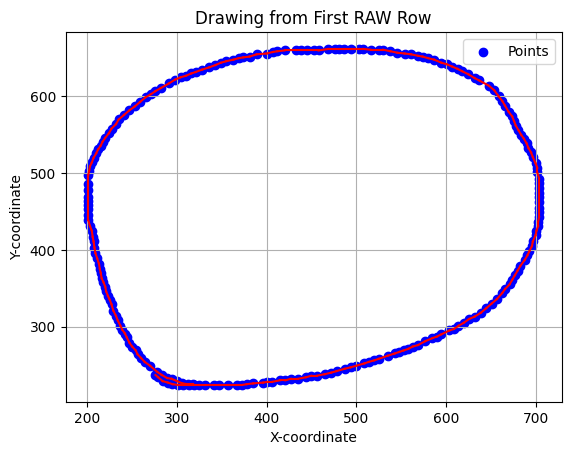

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract data from the first row
first_row = df.loc[0]  # Change the index if needed

# Extract x, y, and time lists
x_values = first_row['drawing'][0]
y_values = first_row['drawing'][1]

# Create a scatter plot of the points
plt.scatter(x_values, y_values, color='blue', marker='o', label='Points')

# Connect the points with lines
for i in range(len(x_values) - 1):
    plt.plot([x_values[i], x_values[i + 1]], [y_values[i], y_values[i + 1]], color='red')

# Customize the plot (add labels, title, etc.)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Drawing from First RAW Row')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


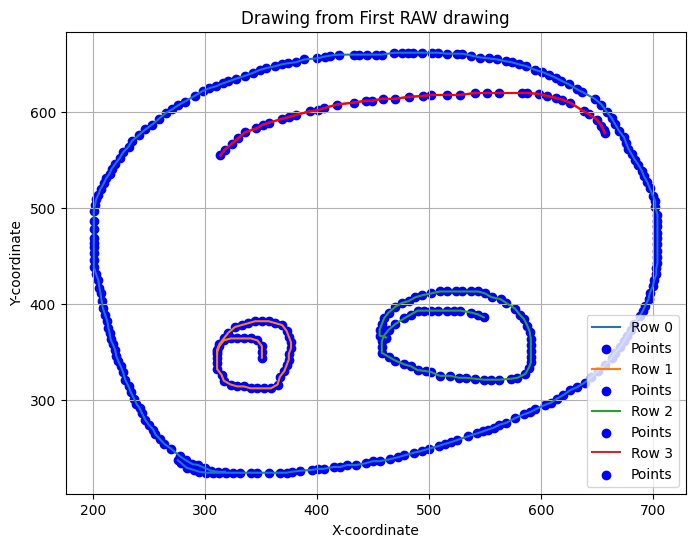

In [16]:
# Extract data from the first drawing 



# Create a new figure for the combined drawing
plt.figure(figsize=(8, 6))

# Iterate through each row and plot the points
num_rows = df.shape[0]
for i in range(num_rows):
    x_values = df.loc[i, 'drawing'][0]
    y_values = df.loc[i, 'drawing'][1]
    plt.plot(x_values, y_values, label=f"Row {i}")

    # Create a scatter plot of the points
    plt.scatter(x_values, y_values, color='blue', marker='o', label='Points')

# Connect the points with lines
for i in range(len(x_values) - 1):
    plt.plot([x_values[i], x_values[i + 1]], [y_values[i], y_values[i + 1]], color='red')

# Customize the plot (add labels, title, etc.)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Drawing from First RAW drawing')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# SIMPLIFIED EXAMPLE

Example taken from the simplfied database on :
https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/simplified

In [17]:
#command to download the examle in terminal: gsutil -m cp 'gs://quickdraw_dataset/full/simplified/axe.ndjson' .

In [18]:
# Download this face file (simplified) and rename it full_simplified_face:
#gsutil -m cp 'gs://quickdraw_dataset/full/simplified/face.ndjson' full_simplified_face.ndjson


In [19]:
current_dir = os.getcwd()

data_simplified_path = os.path.join(os.path.join(os.path.join(current_dir,'..'),'raw_data'),'full_simplified_face.ndjson')

In [20]:
data_simplified_path

'/home/shard777/code/rs-uk/pictionary-ai/notebooks/../raw_data/full_simplified_face.ndjson'

In [21]:
#Simplified DATA: Example 
df2 = pd.DataFrame()
with open(data_simplified_path, 'r') as f:
     for i, line in enumerate(f):
            if i > 0:
                break

            json_line = json.loads(line)
            df2 = pd.concat([df2, pd.DataFrame(json_line)], ignore_index=True)
#             print(type(json_line))
#             print(json_line.keys())
#             print(json_line['word'], len(json_line['drawing']))
            coords = json_line['drawing']
    
            for vector in coords:
                print(len(vector))
                print(vector)
           

2
[[59, 44, 28, 17, 8, 0, 0, 13, 32, 49, 85, 110, 136, 167, 189, 209, 229, 254, 254, 238, 222, 206, 181, 137, 86, 50, 38], [1, 5, 20, 42, 70, 109, 139, 169, 190, 201, 216, 221, 222, 222, 217, 209, 195, 144, 105, 66, 48, 37, 24, 8, 0, 0, 7]]
2
[[76, 76, 71, 59, 56, 56, 61, 72, 83, 89, 86, 79, 64, 56], [61, 67, 71, 70, 64, 55, 47, 45, 47, 68, 78, 80, 77, 63]]
2
[[176, 166, 146, 133, 130, 157, 192, 198, 196, 190, 177, 157, 139, 131, 129, 132], [82, 86, 85, 75, 64, 51, 50, 59, 78, 87, 95, 96, 90, 81, 72, 71]]
2
[[57, 68, 80, 110, 153, 202, 216, 228, 231], [168, 180, 185, 195, 200, 200, 195, 186, 179]]


In [36]:
drawing_test2= df2
drawing_test2

,word,countrycode,timestamp,recognized,key_id,drawing
0,face,CH,2017-03-19 15:52:39.229 UTC,True,5152530285723648,"[[59, 44, 28, 17, 8, 0, 0, 13, 32, 49, 85, 110..."
1,face,CH,2017-03-19 15:52:39.229 UTC,True,5152530285723648,"[[76, 76, 71, 59, 56, 56, 61, 72, 83, 89, 86, ..."
2,face,CH,2017-03-19 15:52:39.229 UTC,True,5152530285723648,"[[176, 166, 146, 133, 130, 157, 192, 198, 196,..."
3,face,CH,2017-03-19 15:52:39.229 UTC,True,5152530285723648,"[[57, 68, 80, 110, 153, 202, 216, 228, 231], [..."


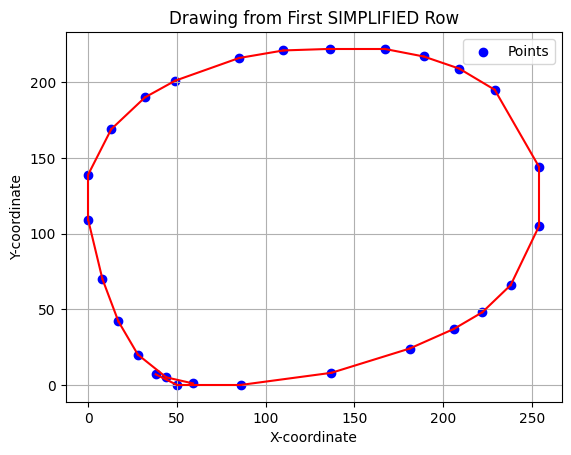

In [23]:
import matplotlib.pyplot as plt
import pandas as pd


# Extract data from the first simplified row
first_row = df2.loc[0]  # Change the index if needed

# Extract x, y, and time lists
x_values = first_row['drawing'][0]
y_values = first_row['drawing'][1]

# Create a scatter plot of the points
plt.scatter(x_values, y_values, color='blue', marker='o', label='Points')

# Connect the points with lines
for i in range(len(x_values) - 1):
    plt.plot([x_values[i], x_values[i + 1]], [y_values[i], y_values[i + 1]], color='red')

# Customize the plot (add labels, title, etc.)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Drawing from First SIMPLIFIED Row')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

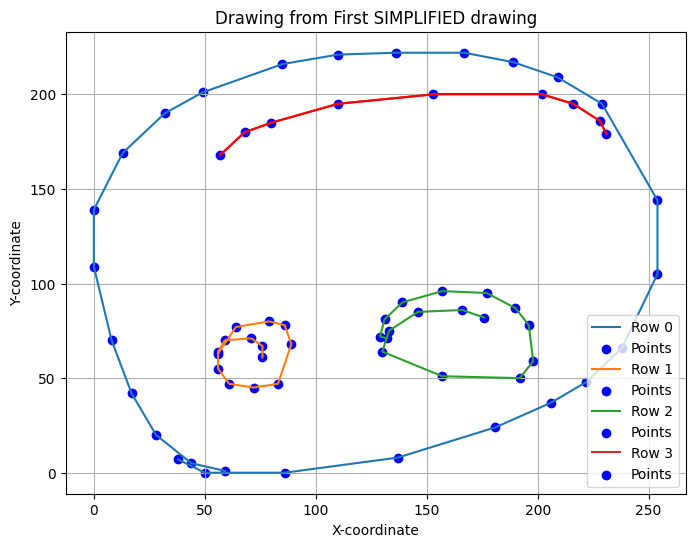

In [24]:
# Extract data from the first SIMPLIFIED drawing 

# Create a new figure for the combined drawing
plt.figure(figsize=(8, 6))

# Iterate through each row and plot the points
num_rows = df2.shape[0]
for i in range(num_rows):
    x_values = df2.loc[i, 'drawing'][0]
    y_values = df2.loc[i, 'drawing'][1]
    plt.plot(x_values, y_values, label=f"Row {i}")

    # Create a scatter plot of the points
    plt.scatter(x_values, y_values, color='blue', marker='o', label='Points')

# Connect the points with lines
for i in range(len(x_values) - 1):
    plt.plot([x_values[i], x_values[i + 1]], [y_values[i], y_values[i + 1]], color='red')

# Customize the plot (add labels, title, etc.)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Drawing from First SIMPLIFIED drawing')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Processing Simplified file

In [182]:
##Define the function to process the Simplified file and return an array and class name (the drawing to guess)
def parse_line(sample):
    """Parse an ndjson line and return ink (as np array) and classname."""
    #sample = json.loads(ndjson_line)
    class_name = sample["word"]
    inkarray = sample["drawing"]
    stroke_lengths = [len(stroke[0]) for stroke in inkarray]
    total_points = sum(stroke_lengths)
    np_ink = np.zeros((total_points, 3), dtype=np.float32)
    current_t = 0
    for stroke in inkarray:
        for i in [0, 1]:
            np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
        current_t += len(stroke[0])
        np_ink[current_t - 1, 2] = 1  # stroke_end

    # Preprocessing.
    # 1. Size normalization.
    lower = np.min(np_ink[:, 0:2], axis=0)
    upper = np.max(np_ink[:, 0:2], axis=0)
    scale = upper - lower
    scale[scale == 0] = 1
    np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale

    # 2. Compute deltas.
    np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
    np_ink = np_ink[1:, :]
    return np.round(np_ink,5), class_name

In [183]:
test_np_ink, class_name = parse_line(df2)
len(test_np_ink[:,0])

65

In [184]:
with open(data_simplified_path, 'r') as f:
     for i, line in enumerate(f):
        json_line = json.loads(line)
        np_ink, class_name = parse_line(json_line)
        print(np_ink)
        print(class_name)
        break

        # if i = n_row:
             # break

[[-0.05906  0.01802  0.     ]
 [-0.06299  0.06757  0.     ]
 [-0.04331  0.0991   0.     ]
 [-0.03543  0.12613  0.     ]
 [-0.0315   0.17568  0.     ]
 [ 0.       0.13514  0.     ]
 [ 0.05118  0.13514  0.     ]
 [ 0.0748   0.09459  0.     ]
 [ 0.06693  0.04955  0.     ]
 [ 0.14173  0.06757  0.     ]
 [ 0.09843  0.02252  0.     ]
 [ 0.10236  0.0045   0.     ]
 [ 0.12205  0.       0.     ]
 [ 0.08661 -0.02252  0.     ]
 [ 0.07874 -0.03604  0.     ]
 [ 0.07874 -0.06306  0.     ]
 [ 0.09843 -0.22973  0.     ]
 [ 0.      -0.17568  0.     ]
 [-0.06299 -0.17568  0.     ]
 [-0.06299 -0.08108  0.     ]
 [-0.06299 -0.04955  0.     ]
 [-0.09843 -0.05856  0.     ]
 [-0.17323 -0.07207  0.     ]
 [-0.20079 -0.03604  0.     ]
 [-0.14173  0.       0.     ]
 [-0.04724  0.03153  1.     ]
 [ 0.14961  0.24324  0.     ]
 [ 0.       0.02703  0.     ]
 [-0.01969  0.01802  0.     ]
 [-0.04724 -0.0045   0.     ]
 [-0.01181 -0.02703  0.     ]
 [ 0.      -0.04054  0.     ]
 [ 0.01969 -0.03604  0.     ]
 [ 0.04331

# Define the function to process a  CLASS (one of the word to guess) full file 

In [143]:
#The function below is not used. After discussion, better use a dictionary of dictionary.
# def word_processing(data_simplified_path, max_images):
#     with open(data_simplified_path, 'r') as f:
#         images_dict = { "word": [], "image_nb": [], "image_key": [], "np_ink": [], "length_np_ink": []} 
#         for i, line in enumerate(f):
#             json_line = json.loads(line)
#             np_ink, class_name = parse_line(json_line)
#             length_np_ink = len(np_ink)
#             images_dict["word"]= json_line["word"]
#             images_dict["image_nb"]= i
#             images_dict["image_key"]= json_line["key_id"]
#             images_dict["np_ink"]= np_ink
#             images_dict["length_np_ink"]= length_np_ink          
#             print(np_ink)
#             print(class_name)
#             i += 1
#             if i == max_images:
#                 break
#     return images_dict
                

In [205]:
def word_processing(data_simplified_path, max_images):
    images_dict = {}  # Initialize an empty dictionary
    with open(data_simplified_path, 'r') as f:
        for i, line in enumerate(f):
            json_line = json.loads(line)
            np_ink, class_name = parse_line(json_line)
            #np_ink= np.round(np_ink,5)
            #print(np_ink)
            length_np_ink = len(np_ink)
            image_info = {
                "word": class_name,
                "image_nb": i,
                "np_ink": np_ink.tolist(),  #need to be transformed to list to dump as Json file later
                "length_np_ink": length_np_ink
            }
            #print(image_info["np_ink"])
            images_dict[json_line["key_id"]] = image_info
            i += 1
            if i == max_images:
                break
    return images_dict


In [208]:
data_simplified_path

'/home/shard777/code/rs-uk/pictionary-ai/notebooks/../raw_data/full_simplified_face.ndjson'

In [209]:
dict_test = word_processing(data_simplified_path, 10)

[[-0.059059999883174896, 0.01802000030875206, 0.0], [-0.06299000233411789, 0.06757000088691711, 0.0], [-0.043310001492500305, 0.09910000115633011, 0.0], [-0.035429999232292175, 0.12612999975681305, 0.0], [-0.03150000050663948, 0.1756799966096878, 0.0], [0.0, 0.13514000177383423, 0.0], [0.051180001348257065, 0.13514000177383423, 0.0], [0.07479999959468842, 0.09459000080823898, 0.0], [0.06693000346422195, 0.049550000578165054, 0.0], [0.14172999560832977, 0.06757000088691711, 0.0], [0.09843000024557114, 0.022520000115036964, 0.0], [0.10236000269651413, 0.0044999998062849045, 0.0], [0.12205000221729279, 0.0, 0.0], [0.08660999685525894, -0.022520000115036964, 0.0], [0.07874000072479248, -0.03604000061750412, 0.0], [0.07874000072479248, -0.06306000053882599, 0.0], [0.09843000024557114, -0.22972999513149261, 0.0], [0.0, -0.1756799966096878, 0.0], [-0.06299000233411789, -0.1756799966096878, 0.0], [-0.06299000233411789, -0.08107999712228775, 0.0], [-0.06299000233411789, -0.049550000578165054, 0

In [195]:
dict_test[list(dict_test.keys())[0]]

{'word': 'face',
 'image_nb': 0,
 'np_ink': [[-0.059059999883174896, 0.01802000030875206, 0.0],
  [-0.06299000233411789, 0.06757000088691711, 0.0],
  [-0.043310001492500305, 0.09910000115633011, 0.0],
  [-0.035429999232292175, 0.12612999975681305, 0.0],
  [-0.03150000050663948, 0.1756799966096878, 0.0],
  [0.0, 0.13514000177383423, 0.0],
  [0.051180001348257065, 0.13514000177383423, 0.0],
  [0.07479999959468842, 0.09459000080823898, 0.0],
  [0.06693000346422195, 0.049550000578165054, 0.0],
  [0.14172999560832977, 0.06757000088691711, 0.0],
  [0.09843000024557114, 0.022520000115036964, 0.0],
  [0.10236000269651413, 0.0044999998062849045, 0.0],
  [0.12205000221729279, 0.0, 0.0],
  [0.08660999685525894, -0.022520000115036964, 0.0],
  [0.07874000072479248, -0.03604000061750412, 0.0],
  [0.07874000072479248, -0.06306000053882599, 0.0],
  [0.09843000024557114, -0.22972999513149261, 0.0],
  [0.0, -0.1756799966096878, 0.0],
  [-0.06299000233411789, -0.1756799966096878, 0.0],
  [-0.062990002334

In [147]:
# Where we want to save the output file and a name is given
output_file = os.path.join(os.path.join(os.path.join(current_dir,'..'),'raw_data'),'face_processed_file.json')

In [148]:
# Function to save the dictionary file for the processed images
def save_images_dict_to_json(images_dict, output_file):
    with open(output_file, 'w') as json_file:
        json.dump(images_dict, json_file)

In [149]:
save_images_dict_to_json(dict_test,output_file)

In [152]:
len(dict_test)

1000

In [153]:
with open(output_file, 'r') as f:
     for i, line in enumerate(f):
        json_line = json.loads(line)
        print(json_line)
        #test_line = parse_line(json_line)
        #print(test_line)
        break

{'5152530285723648': {'word': 'face', 'image_nb': 0, 'np_ink': [[-0.059059999883174896, 0.01802000030875206, 0.0], [-0.06299000233411789, 0.06757000088691711, 0.0], [-0.043310001492500305, 0.09910000115633011, 0.0], [-0.035429999232292175, 0.12612999975681305, 0.0], [-0.03150000050663948, 0.1756799966096878, 0.0], [0.0, 0.13514000177383423, 0.0], [0.051180001348257065, 0.13514000177383423, 0.0], [0.07479999959468842, 0.09459000080823898, 0.0], [0.06693000346422195, 0.049550000578165054, 0.0], [0.14172999560832977, 0.06757000088691711, 0.0], [0.09843000024557114, 0.022520000115036964, 0.0], [0.10236000269651413, 0.0044999998062849045, 0.0], [0.12205000221729279, 0.0, 0.0], [0.08660999685525894, -0.022520000115036964, 0.0], [0.07874000072479248, -0.03604000061750412, 0.0], [0.07874000072479248, -0.06306000053882599, 0.0], [0.09843000024557114, -0.22972999513149261, 0.0], [0.0, -0.1756799966096878, 0.0], [-0.06299000233411789, -0.1756799966096878, 0.0], [-0.06299000233411789, -0.081079997